In [9]:
import os
import numpy as np
import nibabel as nib
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def load_nifti(filepath):
    return nib.load(filepath).get_fdata()

In [ ]:
def normalize(volume):
    mean = np.mean(volume)
    std = np.std(volume)
    # Avoid division by zero
    if std == 0:
        return volume - mean
    return (volume - mean) / std

In [7]:
# --- Main preprocessing logic ---
def preprocess_and_save(data_path, save_path):
    # 1. Create the output directory if it doesn't exist. This prevents errors.
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # 2. Get a list of all patient folder paths inside the main training data directory.
    #    glob(os.path.join(data_path, '*')) finds everything inside data_path.
    subject_dirs = sorted(glob(os.path.join(data_path, '*')))
    
    # 3. Loop through each patient folder. tqdm wraps around this to show a progress bar.
    for subject_dir in tqdm(subject_dirs, desc="Preprocessing Subjects"):
        subject_id = os.path.basename(subject_dir) # Extracts the folder name, e.g., "BraTS-GLI-00518-001"
        
        # 4. Use a try-except block. If one patient folder has a problem (e.g., missing a file),
        #    the script will print an error and continue to the next patient instead of crashing.
        try:
            # 5. Load all 5 NIfTI files for the current patient.
            #    We use glob again to find the file ending with '-t1n.nii.gz', etc.
            t1n = load_nifti(glob(os.path.join(subject_dir, '*-t1n.nii.gz'))[0])
            t1c = load_nifti(glob(os.path.join(subject_dir, '*-t1c.nii.gz'))[0])
            t2w = load_nifti(glob(os.path.join(subject_dir, '*-t2w.nii.gz'))[0])
            t2f = load_nifti(glob(os.path.join(subject_dir, '*-t2f.nii.gz'))[0])
            seg = load_nifti(glob(os.path.join(subject_dir, '*-seg.nii.gz'))[0])

            # 6. THIS IS THE MOST IMPORTANT STEP: Stack and normalize the images.
            #    np.stack takes a list of 4 arrays (each with shape 240x240x155) and
            #    joins them along a new axis (axis=0).
            #    The result is one single array with shape (4, 240, 240, 155).
            image_stack = np.stack([
                normalize(t1n),
                normalize(t1c),
                normalize(t2w),
                normalize(t2f)
            ], axis=0).astype(np.float32) # Convert to float32 for the model.

            # 7. Convert the segmentation mask to a memory-efficient integer type.
            seg = seg.astype(np.uint8)

            # 8. Save the two processed NumPy arrays to the disk in the 'save_path' folder.
            np.save(os.path.join(save_path, f"{subject_id}_img.npy"), image_stack)
            np.save(os.path.join(save_path, f"{subject_id}_seg.npy"), seg)

        except Exception as e:
            print(f"Error processing {subject_id}: {e}")

In [ ]:
# This part makes the script runnable from the command line.
if __name__ == '__main__':
    # Define the paths. You will need to change these to match your folder structure.
    RAW_DATA_PATH = "BRATS-data/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/"
    PROCESSED_DATA_PATH = "BRATS-data/processed/"
    
    # Call the main function to start the process.
    preprocess_and_save(RAW_DATA_PATH, PROCESSED_DATA_PATH)

Preprocessing Subjects: 100%|██████████| 1251/1251 [35:43<00:00,  1.71s/it]


In [10]:
PROCESSED_DATA_PATH = "BRATS-data/processed/"

# Get a list of the processed files
all_image_files = os.listdir(PROCESSED_DATA_PATH)
example_img_file = all_image_files[0] # e.g., 'BraTS-GLI-00518-001_img.npy'
example_seg_file = example_img_file.replace('_img.npy', '_seg.npy')

# --- Load the .npy files ---
image_array = np.load(os.path.join(PROCESSED_DATA_PATH, example_img_file))
seg_array = np.load(os.path.join(PROCESSED_DATA_PATH, example_seg_file))

# --- Print information to understand the data ---
print(f"--- Image Array ---")
print(f"File: {example_img_file}")
print(f"Shape: {image_array.shape}")      # Expected output: (4, 240, 240, 155)
print(f"Data Type: {image_array.dtype}")  # Expected output: float32

print(f"\n--- Segmentation Array ---")
print(f"File: {example_seg_file}")
print(f"Shape: {seg_array.shape}")        # Expected output: (240, 240, 155)
print(f"Data Type: {seg_array.dtype}")    # Expected output: uint8
print(f"Unique labels: {np.unique(seg_array)}") # See the label values (e.g., [0, 1, 2, 3])

--- Image Array ---
File: BraTS-GLI-00658-000_img.npy
Shape: (4, 240, 240, 155)
Data Type: float32

--- Segmentation Array ---
File: BraTS-GLI-00658-000_seg.npy
Shape: (240, 240, 155)
Data Type: uint8
Unique labels: [0 1 2 3]


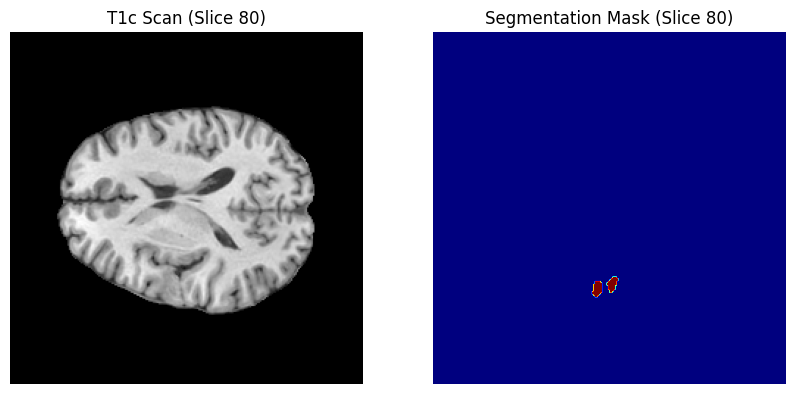

In [16]:
# --- Visualize a slice to confirm it looks right ---
slice_index = 80 # Pick a slice from the middle

# The image_array has 4 channels. Let's visualize the 2nd channel (T1c).
t1c_slice = image_array[0, :, :, slice_index]

# The segmentation array has no channel dimension.
seg_slice = seg_array[:, :, slice_index]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(t1c_slice, cmap='gray')
axes[0].set_title(f'T1c Scan (Slice {slice_index})')
axes[0].axis('off')

axes[1].imshow(seg_slice, cmap='jet') # 'jet' colormap shows different labels in different colors
axes[1].set_title(f'Segmentation Mask (Slice {slice_index})')
axes[1].axis('off')

plt.show()